In [ ]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
train_df = pd.read_csv('./data/train.csv', index_col=0)
test_df = pd.read_csv('./data/test.csv', index_col=0)

# 1. info

In [ ]:
print(train_df.info(), '\n')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472972 entries, 0 to 472971
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   level     472972 non-null  int64 
 1   full_log  472972 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418916 entries, 1000000 to 2418915
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   full_log  1418916 non-null  object
dtypes: object(1)
memory usage: 21.7+ MB
None


+ train 데이터 : full_log 472972개, level은 int형
+ test 데이터 : full_log 1418916개, level을 예측해 submission해야 함

# 2. 중복 확인

In [ ]:
# log 내용이 중복된 것
print(train_df.duplicated(['full_log']).sum())

# log 내용과 level이 중복된 것
print(train_df.duplicated(['full_log', 'level']).sum())

68836
68484


+ 350개 정도가 같은 로그 내용인데도 level이 다름

## 중복되는 로그 내용의 level

In [ ]:
# 중복된 데이터로 구성된 데이터프레임

dubs = train_df[train_df.duplicated('full_log')]

In [ ]:
# level을 set으로 (같은 레벨일 때 카운트 하지 않음)

dubs = dubs.groupby('full_log', as_index=False).agg(lambda x: x.tolist())
dubs.level = dubs.level.apply(set)
dubs

,full_log,level
0,Dec 1 00:00:01 localhost sudo: pam_unix(sudo:...,{1}
1,Dec 1 01:00:01 localhost sudo: pam_unix(sudo:...,{1}
2,Dec 1 02:00:02 localhost sudo: pam_unix(sudo:...,{1}
3,Dec 1 03:00:02 localhost sudo: pam_unix(sudo:...,{1}
4,Dec 1 03:00:02 localhost sudo: pam_unix(sudo:...,{1}
...,...,...
39392,ossec: output: 'netstat listening ports':\ntcp...,{5}
39393,ossec: output: 'netstat listening ports':\ntcp...,{5}
39394,ossec: output: 'netstat listening ports':\ntcp...,{5}
39395,ossec: output: 'netstat listening ports':\ntcp...,{5}


In [ ]:
# 레벨의 개수

dubs['len'] = dubs['level'].str.len()
dubs.sort_values(by=['len'], ascending=False)

,full_log,level,len
39263,"level : 5, log : bind() to port port failed: e...","{0, 1, 5}",3
39105,"level : 5, log : Maximum number of allowed FCo...","{0, 1, 5}",3
39032,"level : 5, log : Dynamic configuration entry f...","{0, 1, 5}",3
39220,"level : 5, log : Unable to obtain hostname for...","{0, 1, 5}",3
38974,"level : 3, log : getwd: error-message","{0, 1, 5}",3
...,...,...,...
13133,"Jan 14 01:03:50 localhost kibana: {""type"":""err...",{0},1
13134,"Jan 14 01:04:00 localhost kibana: {""type"":""err...",{0},1
13135,"Jan 14 01:04:10 localhost kibana: {""type"":""err...",{0},1
13136,"Jan 14 01:04:30 localhost kibana: {""type"":""err...",{0},1


In [ ]:
dubs.len.value_counts()

1    39252
2      137
3        8
Name: len, dtype: int64

+ 같은 레벨에 존재하는 중복값 39252개
+ 두 레벨에 걸쳐 존재하는 중복값 137개
+ 세 레벨에 걸쳐 존재하는 중복값 8개  
(ex) log 내용은 같지만 위험도가 0, 1, 5인 경우가 있다

In [ ]:
for i in range(8):
    print(dubs[dubs.len == 3].full_log.iloc[i], '\n')

level : 3, log : Unable to reinitialize 

level : 3, log : function-name: runtime was excessive (total-time [user-time user, system-time system]) doing action 

level : 3, log : getwd: error-message 

level : 5, log : Dynamic configuration entry for interface interface-name with session id client-session-id found an existing entry with a different session id of client-session-id-1. 

level : 5, log : Maximum number of allowed FCoE filters (slot) reached for this slot maximum-value 

level : 5, log : Unable to obtain hostname for outgoing RADIUS message: error-message 

level : 5, log : attack-name source: source-address, zone name: source-zone-name, interface name: interface-name, action: action 

level : 5, log : bind() to port port failed: error-message 



- 세 위험도(0, 1, 5)에 걸친 여덟 개 로그 데이터는 모두 'level : 3' 혹은 'leve : 5' 로 시작한다

In [ ]:
dubs[dubs.len > 1].full_log.str.extract('^([^ ]+)(?: |$)').value_counts()

level      144
juniper      1
dtype: int64

+ juniper 제외하고, 여러 레벨(2개 or 3개)에 걸친 로그는 모두 level로 시작한다
- level로 시작하는 로그 데이터를 다루는 것이 까다롭겠음

# 3. first words

In [ ]:
train_df['first_word'] = train_df['full_log'].str.extract('^([^ ]+)(?: |$)')

In [ ]:
train_df.first_word.value_counts()

Jan              207025
type=SYSCALL     116496
Feb               35544
Dec               25882
Oct               23883
Sep               23193
Nov               21875
Mar               12174
level              2331
ossec:             1318
File                822
System              820
error:              459
type=AVC            369
oscap:              366
E:                  297
NTFS                 25
2021                 22
Trojaned             15
Windows              13
--MARK--:            12
The                  11
2020                  9
juniper               5
type=USER_AVC         3
OpenSCAP              3
Name: first_word, dtype: int64

## 첫 단어별 레벨

In [ ]:
first_word_level = train_df.pivot_table(values='full_log', index='first_word', columns='level', aggfunc='count', fill_value=0)
first_word_level = first_word_level.loc[train_df['first_word'].value_counts().index]
first_word_level

level,0,1,2,3,4,5,6
Jan,200574,3019,0,3414,1,14,3
type=SYSCALL,0,116496,0,0,0,0,0
Feb,33114,2381,0,44,0,1,4
Dec,24370,1498,0,14,0,0,0
Oct,20973,2904,0,6,0,0,0
Sep,22392,799,1,1,0,0,0
Nov,18980,2646,0,239,9,1,0
Mar,11368,804,0,1,0,0,1
level,1519,736,0,11,0,65,0
ossec:,0,29,0,0,0,1289,0


- [year]
- [Month]
- type=AVC, type=SYSCALL
- System
- File
- level
- error:
- ossec:
- E:
- oscap:
- Windows
- Trojaned
- juniper
- --MARK--:
- NTFS
- The
- OpenSCAP

In [ ]:
# 첫 단어로 묶은 그룹 객체
groups = train_df.groupby('first_word')

## 3-1. level

In [ ]:
level = train_df[train_df['first_word'] == 'level'].copy()
level['log_level'] = level['full_log'].str.extract('level : (\S+),')
level

,level,full_log,first_word,log_level
id,,,,
562,0,"level : 5, log : No mode specified for interfa...",level,5
838,0,"level : 5, log : PIC pic-slot in FPC fpc-slot ...",level,5
1076,5,"level : 10, log : fru-name#fru-slot - command",level,10
1390,0,"level : 5, log : Error getting class usage sta...",level,5
1569,0,"level : 5, log : Fabric fc-fabric-name interfa...",level,5
...,...,...,...,...
471241,0,"level : 3, log : routing socket open error arg...",level,3
471457,0,"level : 10, log : Symmetric key generation fai...",level,10
471722,1,"level : 3, log : Invalid XML data '\\data'",level,3


In [ ]:
pivot_level = level.pivot_table(values='full_log', index='log_level', columns='level', aggfunc='count', fill_value=0)
pivot_level

level,0,1,3,5
log_level,,,,
%{rule.level},10,8,0,0
10,27,13,0,3
2,18,6,0,2
3,593,282,7,18
4,2,2,0,0
5,859,422,4,41
7,10,2,0,0
8,0,1,0,1


In [ ]:
# 비율

pivot_level[[0, 1, 3, 5]] = pivot_level[[0, 1, 3, 5]].apply(lambda x: x/x.sum(), axis=1)
pivot_level.round(2)* 100

level,0,1,3,5
log_level,,,,
%{rule.level},56.0,44.0,0.0,0.0
10,63.0,30.0,0.0,7.0
2,69.0,23.0,0.0,8.0
3,66.0,31.0,1.0,2.0
4,50.0,50.0,0.0,0.0
5,65.0,32.0,0.0,3.0
7,83.0,17.0,0.0,0.0
8,0.0,50.0,0.0,50.0


로그 내 레벨 별 위험도를 확인할 수 있다.  
+ 전체적으로 위험도 0, 1, 3, 5 에만 나타남

In [ ]:
level.log_level.value_counts()

5                1326
3                 900
10                 43
2                  26
%{rule.level}      18
7                  12
4                   4
8                   2
Name: log_level, dtype: int64

In [ ]:
# 로그 내 레벨 별로 하나씩만 뽑아 보기

for j in level.log_level.unique():
    print(level[level.log_level == j].full_log.iloc[0], '\n')

level : 5, log : No mode specified for interface device interface-name; defaulting to port mode 

level : 10, log : fru-name#fru-slot - command 

level : 3, log : Unable to propagate login announcement (motd) to pathname 

level : 2, log : AppTrack session closed reason: source-address/source-port->destination-address/destination-port service-name application nested-application nat-source-address/nat-source-port->nat-destination-address/nat-destination-port src-nat-rule-name dst-nat-rule-name protocol-id policy-name source-zone-name destination-zone-name session-id-32 packets-from-client(bytes-from-client) packets-from-server(bytes-from-server) elapsed-time username roles 

level : %{rule.level}, log : %{log} 

level : 4, log : Assertion failed executable-name[pid]: file source-filename 

level : 7, log : IF interface-name: DCBX TLV version 1.0 received 

level : 8, log : Duplicate slot default: slot 



### level : 숫자, log : 내용

In [ ]:
# log : 내용

level['log_log'] = level['full_log'].str.extract('log : (.+)')
level

,level,full_log,first_word,log_level,log_log
id,,,,,
562,0,"level : 5, log : No mode specified for interfa...",level,5,No mode specified for interface device interfa...
838,0,"level : 5, log : PIC pic-slot in FPC fpc-slot ...",level,5,PIC pic-slot in FPC fpc-slot (type pic-type: p...
1076,5,"level : 10, log : fru-name#fru-slot - command",level,10,fru-name#fru-slot - command
1390,0,"level : 5, log : Error getting class usage sta...",level,5,Error getting class usage statistics for inter...
1569,0,"level : 5, log : Fabric fc-fabric-name interfa...",level,5,Fabric fc-fabric-name interface interface-name...
...,...,...,...,...,...
471241,0,"level : 3, log : routing socket open error arg...",level,3,routing socket open error argument
471457,0,"level : 10, log : Symmetric key generation fai...",level,10,Symmetric key generation failure: error-message
471722,1,"level : 3, log : Invalid XML data '\\data'",level,3,Invalid XML data '\\data'


In [ ]:
print(level.duplicated('log_log').sum()) # log: 뒤 내용이 중복
print(level.duplicated(['log_level','log_log']).sum())
# level과 log뒤 내용까지 중복

1057
1056


In [ ]:
print(level.log_log.isnull().sum()) # 결측 없음

0


In [ ]:
len(level.log_log.unique()) # 1274 종류의 로그메세지 (나머진 중복)

1274

In [ ]:
level.log_level.unique()

array(['5', '10', '3', '2', '%{rule.level}', '4', '7', '8'], dtype=object)

## level: 별 log: 메세지들 

In [ ]:
level[level.log_level == '2'].log_log

id
19807     AppTrack session closed reason: source-address...
86051     Usage: executable-name [-c] [-C] [-n] [-N] [-t...
89956     Lsys logical-system-name: AppTrack session clo...
91427     Lsys logical-system-name: session created sour...
94452     AppTrack app update: source-address/source-por...
101242    Lsys logical-system-name: AppTrack volume upda...
125718    argument supersedes forwarding-class under pol...
126682    Lsys logical-system-name: IDP: At epoch-time, ...
142924    syslog-prefix error-code: proto protocol-id (p...
149383    DDOS Attack at epoch-time on ddos-application-...
168990    AppTrack app update: source-address/source-por...
175816    Lsys logical-system-name: session closed reaso...
176261    session closed reason: source-address/source-p...
180948    AppTrack session created source-address/source...
207838    Lsys logical-system-name: DDOS Application thr...
218135    session created source-address/source-port->de...
263685    Usage: executable-name [-c]

In [ ]:
level[level.log_level == '3'].log_log

id
1870      Unable to propagate login announcement (motd) ...
2195                                  reason: error-message
2427                    Task pthread worker creation failed
2770              This is test alarm argument1 of argument2
2828      Invalid policy managerhandle to uninitialize s...
                                ...                        
466640    MPLS LSP lsp-name change on path-type(pathname...
469601    Unable to add tunnel group tunnel-group (servi...
471241                   routing socket open error argument
471722                            Invalid XML data '\\data'
471998                              pathname: error-message
Name: log_log, Length: 900, dtype: object

In [ ]:
level[level.log_level == '4'].log_log # 모두 같음

id
29302     Assertion failed executable-name[pid]: file so...
205309    Assertion failed executable-name[pid]: file so...
213214    Assertion failed executable-name[pid]: file so...
392674    Assertion failed executable-name[pid]: file so...
Name: log_log, dtype: object

In [ ]:
level[level.log_level == '5'].log_log

id
562       No mode specified for interface device interfa...
838       PIC pic-slot in FPC fpc-slot (type pic-type: p...
1390      Error getting class usage statistics for inter...
1569      Fabric fc-fabric-name interface interface-name...
1663      Failed to parse community string under policy-...
                                ...                        
469600    Nonzero ICMP code (value) for router solicitat...
470345    Maximum number of allowed FCoE filters (slot) ...
470502    No ike-policy found for ike-access-profile: ac...
470540    Unable to create interface devices during atta...
472338    function-name: fru-name operation error: reaso...
Name: log_log, Length: 1326, dtype: object

In [ ]:
level[level.log_level == '7'].log_log

id
50825      IF interface-name: DCBX TLV version 1.0 received
84028                      Unable to open PID file filename
107784          Fabric fc-fabric-name fabric-wwn is cleared
118755                   Unable to lock PID file 'filename'
188372    Assertion failed executable-name[pid]: file so...
208346                              Unable to lock pid file
222061                  rtsock rewrite type type is invalid
289042    Assertion failed executable-name[pid]: file so...
323896                   Unable to lock PID file 'filename'
330509     IF interface-name: DCBX TLV version 1.0 received
368319    Assertion failed executable-name[pid]: file so...
459764    Assertion failed executable-name[pid]: file so...
Name: log_log, dtype: object

In [ ]:
level[level.log_level == '8'].log_log # 모두 같음

id
76537     Duplicate slot default: slot
406263    Duplicate slot default: slot
Name: log_log, dtype: object

In [ ]:
level[level.log_level == '10'].log_log

id
1076                            fru-name#fru-slot - command
6196                            Key-Pair has been generated
8675                      fru-name fru-slot already offline
20890                        Key type = type, not supported
22685                              type username is invalid
29074                    License key filename has expired."
29240                                     fru-name: message
32250               executable-name: invalid switch: option
47119                                       EMERG: argument
48953                      Skipped empty object 'node-name'
60975              Taking fru-name fru-slot offline: reason
62182              sigaction(SIGsignal-name): error-message
69574              sigaction(SIGsignal-name): error-message
87648                              type username is invalid
97446                            BEEP initialization failed
107584             sigaction(SIGsignal-name): error-message
136304                             Ke

> juniper 로그 메세지 설명서 참고
+ level : 이 무엇인지는 여전히 미궁이다 (어쩌면 심각도가 아니라 시스템 계층의 레벨...?)

## 3-2. [Month]
그 다음에 오는 단어 (second_word)
- localhost
- sv260
- m2datateksolaris

In [ ]:
MONTH = {'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'}
log_time = train_df[train_df['first_word'].isin(MONTH)].copy()
log_time

,level,full_log,first_word
id,,,
0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err...",Sep
1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...,Feb
2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err...",Jan
3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err...",Jan
6,0,"Jan 22 06:28:59 localhost kibana: {""type"":""err...",Jan
...,...,...,...
472966,0,Mar 5 20:33:06 localhost logstash: 14312 ...,Mar
472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:,Feb
472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log...",Oct


In [ ]:
log_time_level = log_time.pivot_table(values='full_log', index='first_word', columns='level', aggfunc='count', fill_value=0)

In [ ]:
log_time['second_word'] = log_time['full_log'].str.extract('\d{2}:\d{2}:\d{2} (\S+) ')
log_time

,level,full_log,first_word,second_word
id,,,,
0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err...",Sep,localhost
1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...,Feb,localhost
2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err...",Jan,localhost
3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err...",Jan,localhost
6,0,"Jan 22 06:28:59 localhost kibana: {""type"":""err...",Jan,localhost
...,...,...,...,...
472966,0,Mar 5 20:33:06 localhost logstash: 14312 ...,Mar,localhost
472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:,Feb,localhost
472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log...",Oct,localhost


In [ ]:
# sshd 뒤 포트 번호는 무시
log_time_localhost = log_time[log_time.second_word=='localhost']
log_time_localhost['third_word'] = log_time_localhost['full_log'].str.extract('localhost ([^ \[]+)(?::|\[)')
log_time_localhost

,level,full_log,first_word,second_word,third_word
id,,,,,
0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err...",Sep,localhost,kibana
1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...,Feb,localhost,logstash
2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err...",Jan,localhost,kibana
3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err...",Jan,localhost,kibana
6,0,"Jan 22 06:28:59 localhost kibana: {""type"":""err...",Jan,localhost,kibana
...,...,...,...,...,...
472966,0,Mar 5 20:33:06 localhost logstash: 14312 ...,Mar,localhost,logstash
472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:,Feb,localhost,logstash
472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log...",Oct,localhost,kibana


In [ ]:
log_time_localhost.third_word.value_counts()
log_time_localhost.third_word.unique()

array(['kibana', 'logstash', 'esild-ml-start.sh', 'suricata', 'sudo',
       'systemd', 'sshd', 'mcelog', 'auditd', 'kernel', 'unix_chkpwd',
       'journal', 'postfix/master', 'yum', 'augenrules', 'rc.local',
       'elasticsearch', 'polkitd', 'su', 'useradd', 'dbus', 'kdumpctl',
       'pulseaudio', 'bluetoothd', 'gnome-session', 'dbus-daemon'],
      dtype=object)

In [ ]:
log_time_localhost.pivot_table(values='full_log', index='third_word', columns=['level'], aggfunc='count', fill_value=0)

level,0,1,2,3,4,5,6
third_word,,,,,,,
auditd,510,0,0,0,0,0,0
augenrules,8,0,0,0,0,0,0
bluetoothd,2,0,0,0,0,0,0
dbus,1,0,0,0,0,0,0
dbus-daemon,1,0,0,0,0,0,0
elasticsearch,7,0,0,0,0,0,0
esild-ml-start.sh,4383,0,0,0,0,0,0
gnome-session,1,0,0,0,0,0,0
journal,92,0,0,0,0,0,0


In [ ]:
new = log_time_localhost[log_time_localhost.third_word == 'kibana'].full_log.str.len()
log_time_localhost.loc[464042]

level                                                          0
full_log       Jan 25 16:57:42 localhost kibana: {"type":"err...
first_word                                                   Jan
second_word                                            localhost
third_word                                                kibana
Name: 464042, dtype: object

In [ ]:
level.iloc[464042]

IndexError: single positional indexer is out-of-bounds

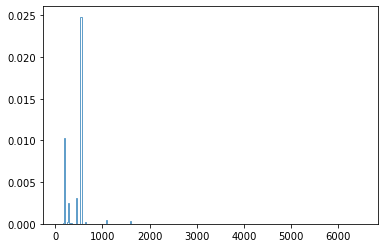

In [ ]:
plt.hist(new.values, bins=273, density=True, alpha=0.7, histtype='step')
plt.show()